Loading the Image:/scratch/railabs/ft42/VLST_Project/Data/LUNA25/luna25_images_resampled/1.2.840.113654.2.55.323804676332963457174235140303454945005.nii.gz
Intial_boxes=20,filrted prob=0.8, filtered_boxes =5
Annotation-Numbers=1


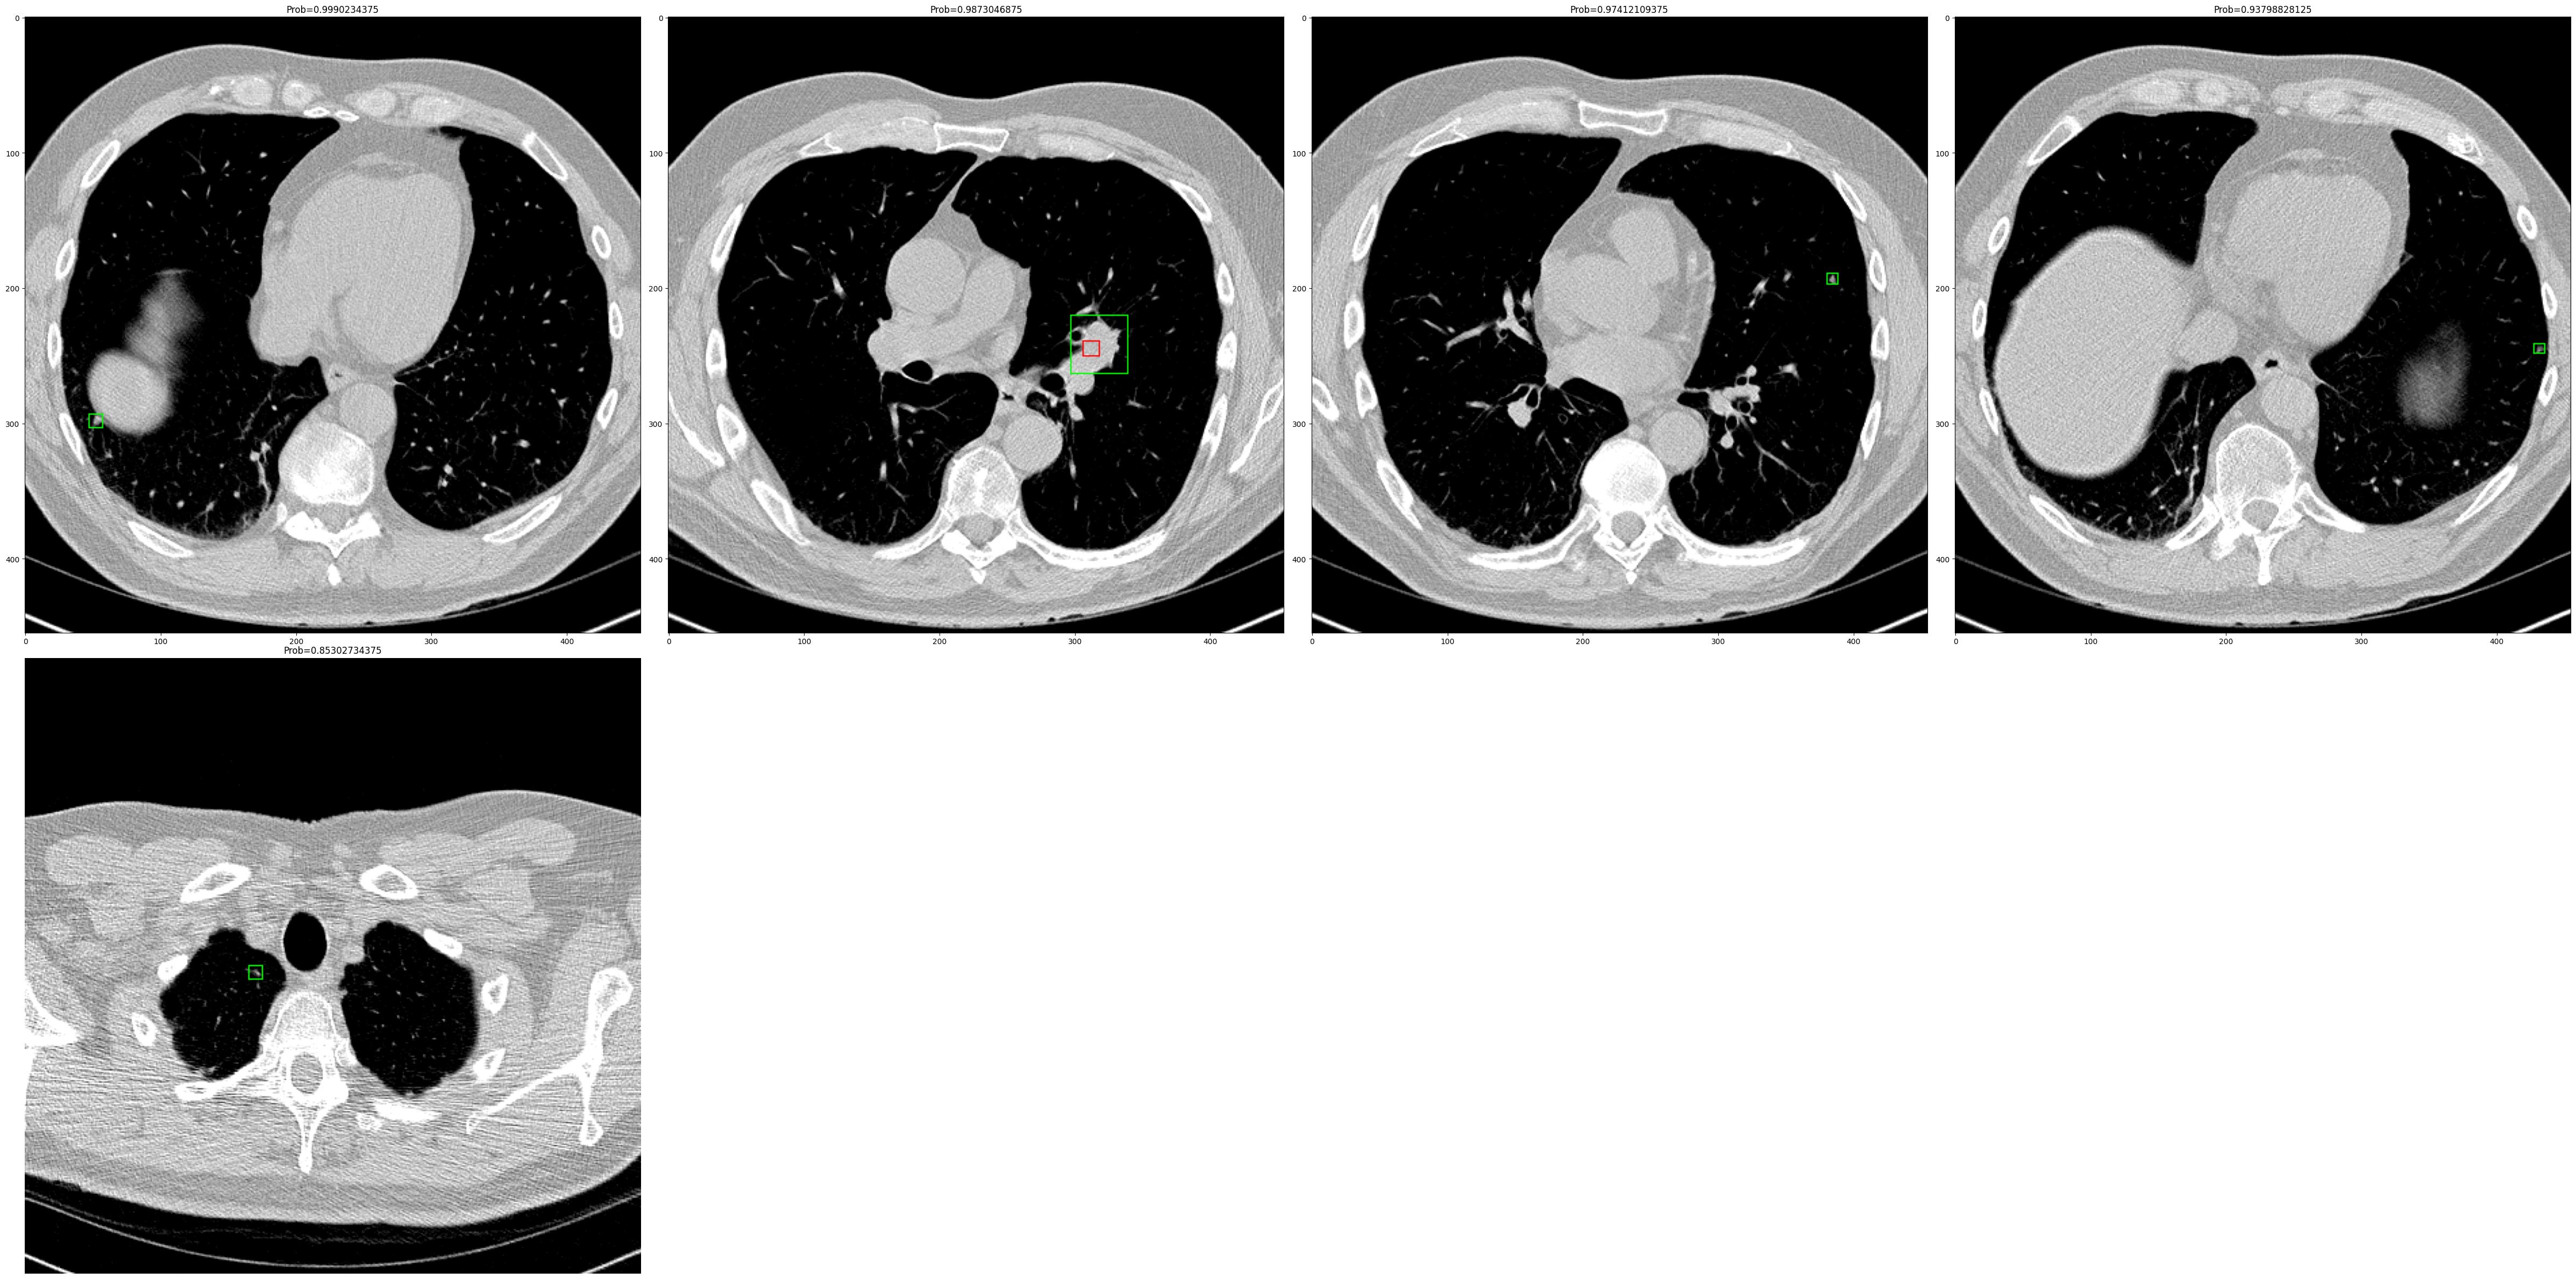

In [2]:
import cv2
import numpy as np
import SimpleITK as sitk
import csv
import os
from PIL import Image
import matplotlib.pyplot as plt
import math
import json
import pandas as pd

#-| Functions

def load_itk_image(filename):
    itkimage = sitk.ReadImage(filename)
    numpyImage = sitk.GetArrayFromImage(itkimage)
    numpyOrigin = np.array(list(reversed(itkimage.GetOrigin())))
    numpySpacing = np.array(list(reversed(itkimage.GetSpacing())))
    return numpyImage, numpyOrigin, numpySpacing

def worldToVoxelCoord(worldCoord, origin, spacing):
    stretchedVoxelCoord = np.absolute(worldCoord - origin)
    voxelCoord = stretchedVoxelCoord / spacing
    return voxelCoord

def normalize_image_to_uint8(image, min_val=-800, max_val=300):
    image = image.astype(np.float32)
    image = np.clip(image, min_val, max_val)
    image = (image - min_val) / (max_val - min_val)
    return (image * 255).astype(np.uint8)

#-| Load Ground Truth CSV

gt_csv_path = '/NAS/shared_data/for_VNLST/ft42/ct_public/LUNA25/LUNA25_Public_Training_Development_Data_AnnotationID_nifti.csv' 
gt_df = pd.read_csv(gt_csv_path)

#-| Load predictions

f = open('/NAS/shared_data/for_VNLST/ft42/ct_public/LUNA25/Detection_results/result_DukeLungRADs_cvit_luna16_BaseModel_epoch300_patch192x192y80z_fold1_DukeLungRADs_LUNA25tr.json')
resampled_img_path = 'luna25_images_resampled/'
Final_dect = json.load(f)

for IM_TO_READ in range(0, 1):

    example_dictionary = Final_dect['validation'][IM_TO_READ]
    img_name = example_dictionary["image"].split('/')[-1]
    print('Loading the Image:{}'.format(example_dictionary["image"]))

    numpyImage, numpyOrigin, numpySpacing = load_itk_image(filename=resampled_img_path + img_name)

    probabilities_roi = .80

    Box_filtering = [i >= probabilities_roi for i in example_dictionary["score"]]
    Box_filtering = [int(value) for value in Box_filtering]
    index_values = [index for index, value in enumerate(Box_filtering) if value == 1]
    print('Intial_boxes={},filrted prob={}, filtered_boxes ={}'.format(len(Box_filtering),probabilities_roi,len(index_values)))
    current_gt = gt_df[gt_df['SeriesInstanceUID'] == img_name.replace('.nii.gz', '')]
    print('Annotation-Numbers={}'.format(len(current_gt)))

    number_of_predictive_variables = sum(Box_filtering)

    if number_of_predictive_variables >= 1:
        subplot_number_of_colums = 4
        subplot_number_of_rows = math.ceil(number_of_predictive_variables / subplot_number_of_colums)
        fig_size = ( 24* subplot_number_of_rows, 12 * subplot_number_of_rows)
        fig = plt.figure(figsize=fig_size)

        for index, Which_box_to_use in enumerate(index_values):

            worldCoord = np.asarray([float(example_dictionary["box"][Which_box_to_use][2]),
                                     float(example_dictionary["box"][Which_box_to_use][1]),
                                     float(example_dictionary["box"][Which_box_to_use][0])])
            voxelCoord = worldToVoxelCoord(worldCoord, numpyOrigin, numpySpacing)

            start_x = int(voxelCoord[2] - example_dictionary["box"][Which_box_to_use][3])
            end_x = int(voxelCoord[2] + example_dictionary["box"][Which_box_to_use][3])

            start_y = int(voxelCoord[1] - example_dictionary["box"][Which_box_to_use][4])
            end_y = int(voxelCoord[1] + example_dictionary["box"][Which_box_to_use][4])

            start_z = int(voxelCoord[0] - example_dictionary["box"][Which_box_to_use][5])
            end_z = int(voxelCoord[0] + example_dictionary["box"][Which_box_to_use][5])

            draw_box_z = int(voxelCoord[0])
            draw_img = normalize_image_to_uint8(numpyImage[draw_box_z, :, :])
            draw_img = cv2.cvtColor(draw_img, cv2.COLOR_GRAY2BGR)

            draw_img = cv2.rectangle(draw_img,
                                     pt1=(start_x, start_y),
                                     pt2=(end_x, end_y),
                                     color=(0, 255, 0),
                                     thickness=1)

            # Ground Truth Matching

            
            for _, gt_row in current_gt.iterrows():
                gt_worldCoord = np.array([gt_row['CoordZ'], gt_row['CoordY'], gt_row['CoordX']])
                distance = np.linalg.norm(worldCoord - gt_worldCoord)

                if distance <= 8:
                    gt_voxelCoord = worldToVoxelCoord(gt_worldCoord, numpyOrigin, numpySpacing)
                    gt_start_x = int(gt_voxelCoord[2] - 4 / numpySpacing[2])
                    gt_end_x = int(gt_voxelCoord[2] + 4 / numpySpacing[2])
                    gt_start_y = int(gt_voxelCoord[1] - 4 / numpySpacing[1])
                    gt_end_y = int(gt_voxelCoord[1] + 4 / numpySpacing[1])

                    draw_img = cv2.rectangle(draw_img,
                                             pt1=(gt_start_x, gt_start_y),
                                             pt2=(gt_end_x, gt_end_y),
                                             color=(255, 0, 0),
                                             thickness=1)

            ax = fig.add_subplot(subplot_number_of_rows, subplot_number_of_colums, 1 + index)
            ax.imshow(draw_img, cmap='gray')
            ax.set_title('Prob={}'.format(example_dictionary["score"][Which_box_to_use]))

        plt.tight_layout()
        plt.axis('off')
        plt.show()

# Detection-Results Analysis

In [15]:
import sys
sys.path.append('/NAS/user_data/user/ft42/LungRADS_Modeling/LungRADS_Detection/')

from eval_utils import*



start_fold                 = 1
end_fold                   = 2
run_version                = "result_DukeLungRADs_cvit_luna16_BaseModel_epoch300_patch192x192y80z_fold1_DukeLungRADs_LUNA25tr"
Model_save_path_and_utils  = '/NAS/shared_data/for_VNLST/ft42/ct_public/LUNA25/Detection_results/'
raw_result_json_folder     = Model_save_path_and_utils
saved_folder               = Model_save_path_and_utils
dataset_split_path         = '/data/usr/ft42/CVIT_XAI/MONAI/ct_detection/RetinaNet_Detections/datasplit_folds/'
Annotation_csv             = '/NAS/shared_data/for_VNLST/ft42/ct_public/LUNA25/LUNA25_Public_Training_Development_Data_AnnotationID_nifti.csv' 
Eval_validation            = True
Eval_training              = True


    
dictionary_arg = "validation"
json_path      = raw_result_json_folder +'{}.json'.format(run_version, folds)
csv_path       = saved_folder           +'{}.csv'.format(run_version,  folds) 
result_json_to_result_csv(dictionary_arg,json_path,csv_path)
        
        

json_to_read            = '/NAS/shared_data/for_VNLST/ft42/ct_public/LUNA25/LUNA25_Public_Training_Development_Data_Valimg.json'
dict_to_read            = dictionary_arg
key_to_read             = "image"
annotation_image_list   = read_json_to_dict_return_image_name(dict_to_read,key_to_read,json_to_read)
annotation_image_list   = [path.split('.nii.gz')[0] for path in annotation_image_list]
annotation_image_list   

read_cxr_df             = pd.read_csv(csv_path)
predicted_image_list    = read_cxr_df['seriesuid'].tolist()
uncommon_values         = list(set(annotation_image_list) ^ set(predicted_image_list))
print(len(uncommon_values))
if len(uncommon_values) > 0:
    columns       = read_cxr_df.columns
    missing_pt_df = pd.DataFrame([[0] * len(columns)] * len(uncommon_values), columns=columns)
    missing_pt_df['seriesuid'] =  uncommon_values
    read_cxr_df = pd.concat([read_cxr_df,missing_pt_df],ignore_index=True).reset_index(drop=True)
    read_cxr_df.to_csv(csv_path,encoding='utf-8',index=False)



        #Generate_matches_GT_for_LROC(predict,gt)

gt_csv      = Annotation_csv
predict_csv = saved_folder+'{}.csv'.format(run_version,folds)
saving_csv  = saved_folder+'{}_withGT.csv'.format(run_version,folds)
#-Prediction
print(saving_csv.split('/')[-1])
predict_df         = pd.read_csv(predict_csv)
result_UniPatient  = np.unique(predict_df['seriesuid'].tolist())
print('Predicted-boxes= {}'.format(len(predict_df)))
print('Unique-Patient = {}'.format(len(result_UniPatient)))

#-Annotation Filtering
Annotation = pd.read_csv(gt_csv)
Annotation['seriesuid'] = Annotation['SeriesInstanceUID']
Annotation = Annotation[Annotation['seriesuid'].isin(result_UniPatient)]
Annotation = Annotation.reset_index(drop=True)
Annotation['coordX'] = Annotation['CoordX']
Annotation['coordY'] = Annotation['CoordY'] 
Annotation['coordZ'] = Annotation['CoordZ'] 
Annotation['diameter_mm'] = 8 

print('Annotation-UniPatient={}'.format(len(np.unique(Annotation['seriesuid'].tolist()))))
groud_th_added = Generate_matches_GT_for_LROC(predict=predict_df,gt=Annotation)
groud_th_added.to_csv(saving_csv,index=False,encoding='utf-8')


4
result_DukeLungRADs_cvit_luna16_BaseModel_epoch300_patch192x192y80z_fold1_DukeLungRADs_LUNA25tr_withGT.csv
Predicted-boxes= 74283
Unique-Patient = 4069
Annotation-UniPatient=4069
processing-1.2.840.113654.2.55.323804676332963457174235140303454945005,PredCandidate:20, GT:1
processing-1.2.840.113654.2.55.169309936075332267797085665689677792004,PredCandidate:8, GT:1
processing-1.2.840.113654.2.55.137284376304168395503445289171119065795,PredCandidate:7, GT:1
processing-1.2.840.113654.2.55.40415300708683206534849072667057253335,PredCandidate:17, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.241362276021415962957757016841,PredCandidate:9, GT:2
processing-1.2.840.113654.2.55.94518475546509771370984195173527757543,PredCandidate:8, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.126771866502337542200291083051,PredCandidate:11, GT:1
processing-1.2.840.113654.2.55.243017579918509781292996223521638986821,PredCandidate:13, GT:1
processing-1.2.840.113654.2.55.62102832281866128335133952467331

processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.318306490005426650756067726172,PredCandidate:6, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.522701259718906859031277147656,PredCandidate:9, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.282605138934435721988472315082,PredCandidate:7, GT:1
processing-1.2.840.113654.2.55.149234022456089227205930501120011421476,PredCandidate:12, GT:1
processing-1.2.840.113654.2.55.202590990749233587270867529690119914374,PredCandidate:15, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.118167929221277753779690567136,PredCandidate:26, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.136301467432372202868821109113,PredCandidate:29, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.157420894721835290450893682226,PredCandidate:15, GT:1
processing-1.2.840.113654.2.55.307717989175320186382946655398151123616,PredCandidate:11, GT:1
processing-1.2.840.113654.2.55.187488516158751447197073642392431374839,PredCandidate:39, GT:1
processing-1.2.840.113654.2.55.26

processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.161520031503779249552913486421,PredCandidate:19, GT:6
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.311119362574023477506809299054,PredCandidate:14, GT:1
processing-1.2.840.113654.2.55.292934474273108094246973815302497229007,PredCandidate:17, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.289489929610966663512233104699,PredCandidate:12, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.208457477941676527866368283423,PredCandidate:9, GT:1
processing-1.2.840.113654.2.55.270184556347436715961946782950124588626,PredCandidate:7, GT:1
processing-1.2.840.113654.2.55.4798158659548876821203067227189847810,PredCandidate:8, GT:1
processing-1.2.840.113654.2.55.128924791148552059609231933459828069914,PredCandidate:17, GT:1
processing-1.2.840.113654.2.55.169459653984538996089118801118357450717,PredCandidate:9, GT:1
processing-1.2.840.113654.2.55.27810048928824119965097676523232898904,PredCandidate:9, GT:1
processing-1.2.840.113654.2.55.25005057909906081

processing-1.2.840.113654.2.55.171600902594028622397753720861992381949,PredCandidate:13, GT:2
processing-1.2.840.113654.2.55.318379336523366174720938941155174133682,PredCandidate:60, GT:1
processing-1.2.840.113654.2.55.317890908728283288001501765034881501473,PredCandidate:17, GT:2
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.314506645627826539605202404934,PredCandidate:11, GT:2
processing-1.2.840.113654.2.55.201664009347634165187058934797193112306,PredCandidate:11, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.272294119166791897224680245657,PredCandidate:23, GT:5
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.304021728307790565972461001542,PredCandidate:25, GT:5
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.202822603992564216420306527671,PredCandidate:16, GT:1
processing-1.2.840.113654.2.55.109402491221800452068018740699268052618,PredCandidate:9, GT:3
processing-1.2.840.113654.2.55.100611742735489496565047882309637972403,PredCandidate:12, GT:3
processing-1.2.840.113654.2.55.2601562558

processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.337989011907778782753651851514,PredCandidate:40, GT:2
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.165939265095044249782897625876,PredCandidate:46, GT:2
processing-1.2.840.113654.2.55.339732965054705978812868247109739795492,PredCandidate:14, GT:1
processing-1.2.840.113654.2.55.52701581827754897811957888266166316283,PredCandidate:6, GT:1
processing-1.2.840.113654.2.55.274398380832150835510520871274062817106,PredCandidate:3, GT:1
processing-1.2.840.113654.2.55.111683146815884958852504435146773582939,PredCandidate:4, GT:1
processing-1.2.840.113654.2.55.34503483513285606337066584858931549846,PredCandidate:11, GT:2
processing-1.2.840.113654.2.55.11420688549653101618056848080827817147,PredCandidate:10, GT:2
processing-1.2.840.113654.2.55.178995998972841550730023114198940172142,PredCandidate:11, GT:1
processing-1.2.840.113654.2.55.86105495484221334714823026048876078417,PredCandidate:41, GT:6
processing-1.2.840.113654.2.55.30493959144011709992259728

processing-1.2.840.113654.2.55.144397296658897716362314050100536753460,PredCandidate:35, GT:3
processing-1.2.840.113654.2.55.182717145941459198339902825651484854328,PredCandidate:29, GT:3
processing-1.2.840.113654.2.55.328581103227600874835847374904168668450,PredCandidate:5, GT:1
processing-1.2.840.113654.2.55.36238096229036769137908755873264386359,PredCandidate:7, GT:1
processing-1.2.840.113654.2.55.84898372734456379503297814458982462957,PredCandidate:7, GT:1
processing-1.2.840.113654.2.55.46836332970335027846608545598759071945,PredCandidate:5, GT:1
processing-1.2.840.113654.2.55.50161875835992176235295618969661619822,PredCandidate:13, GT:1
processing-1.2.840.113654.2.55.98505665653010872320817107881049787996,PredCandidate:21, GT:3
processing-1.2.840.113654.2.55.292281123552320162834980911964722629872,PredCandidate:4, GT:2
processing-1.2.840.113654.2.55.124599163634214680211985941297178467081,PredCandidate:4, GT:2
processing-1.2.840.113654.2.55.262613979294916150044852012890473553160,

processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.834325337116906565279633062402,PredCandidate:4, GT:1
processing-1.2.840.113654.2.55.99957942735831654347218710024428759420,PredCandidate:12, GT:1
processing-1.2.840.113654.2.55.202240659320301993342485928638009925024,PredCandidate:11, GT:1
processing-1.2.840.113654.2.55.195371929727289125322220779631085707043,PredCandidate:17, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.107926606736506106901973163405,PredCandidate:26, GT:1
processing-1.2.840.113654.2.55.56285260398953600196027519242670258214,PredCandidate:12, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.243900956094282730414452805382,PredCandidate:8, GT:2
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.140325825264455771625503438954,PredCandidate:11, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.330648611647506498526866093590,PredCandidate:11, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.320905585802300549291367017511,PredCandidate:8, GT:2
processing-1.3.6.1.4.1.14519.5.2.1.

processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.144597356678732949948307951503,PredCandidate:40, GT:2
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.775675734133432355484526519317,PredCandidate:64, GT:2
processing-1.2.840.113654.2.55.308827644279899465382137486506057923263,PredCandidate:74, GT:4
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.371579775666481788679945954044,PredCandidate:4, GT:1
processing-1.2.840.113654.2.55.141015348401308435474905159382971813358,PredCandidate:19, GT:1
processing-1.2.840.113654.2.55.221050706251214227498982092377591191089,PredCandidate:24, GT:1
processing-1.2.840.113654.2.55.160670949588917359393574517832128033994,PredCandidate:24, GT:1
processing-1.2.840.113654.2.55.164207939351126602717445858391758762787,PredCandidate:19, GT:2
processing-1.2.840.113654.2.55.323879729444643695896771886043643923881,PredCandidate:18, GT:1
processing-1.2.840.113654.2.55.9591894783207772540741120585570752313,PredCandidate:19, GT:1
processing-1.2.840.113654.2.55.22990631533655404

processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.266723448417896775634316863647,PredCandidate:30, GT:2
processing-1.2.840.113654.2.55.244529842686074707729538733323080063293,PredCandidate:17, GT:1
processing-1.2.840.113654.2.55.10001915497607871704679012670488177360,PredCandidate:21, GT:1
processing-1.2.840.113654.2.55.242752460639480265515153750226889495868,PredCandidate:20, GT:1
processing-1.2.840.113654.2.55.257641365915625891917779068301224302733,PredCandidate:12, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.226462814297397915442471718448,PredCandidate:10, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.160311508232687326101115404025,PredCandidate:15, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.288084276279488307379386222507,PredCandidate:10, GT:2
processing-1.2.840.113654.2.55.192589531670356439771390492342208555607,PredCandidate:9, GT:1
processing-1.2.840.113654.2.55.118191260550781181296207447997167476169,PredCandidate:23, GT:2
processing-1.2.840.113654.2.55.11539346934

processing-1.2.840.113654.2.55.41091495790610194459724135577096464690,PredCandidate:12, GT:1
processing-1.2.840.113654.2.55.159725507544375963773126641035360361630,PredCandidate:15, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.116685732054089944350172542722,PredCandidate:7, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.330336216348517794782609102773,PredCandidate:12, GT:1
processing-1.2.840.113654.2.55.304335679164252278995630941186617191611,PredCandidate:17, GT:1
processing-1.2.840.113654.2.55.114338727515724835765838983231231689123,PredCandidate:21, GT:1
processing-1.2.840.113654.2.55.317139556472719024789009439932583588751,PredCandidate:14, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.535429846806879730758167799634,PredCandidate:10, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.137897003058972140977291801741,PredCandidate:25, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.131131828321708464413596959557,PredCandidate:15, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.70

processing-1.2.840.113654.2.55.123320763048971011795377196001797117915,PredCandidate:11, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.105106774153771612978491223792,PredCandidate:23, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.110564479077464108932103555942,PredCandidate:35, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.564506291211196036774302813300,PredCandidate:31, GT:1
processing-1.2.840.113654.2.55.137972921507113152150771739783816156681,PredCandidate:38, GT:3
processing-1.2.840.113654.2.55.75439464289523706508402610684302460693,PredCandidate:42, GT:3
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.326813522341688179895289557622,PredCandidate:33, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.326149523004766904439789375606,PredCandidate:31, GT:2
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.328762816994598051397606811884,PredCandidate:31, GT:1
processing-1.2.840.113654.2.55.239490176524684007311016408599425700577,PredCandidate:31, GT:2
processing-1.2.840.113654.2.55.

processing-1.2.840.113654.2.55.95680174467740512709264398520559855595,PredCandidate:28, GT:2
processing-1.2.840.113654.2.55.36806234737263414591753566364186809933,PredCandidate:21, GT:1
processing-1.2.840.113654.2.55.99949097566505258224104507491819590712,PredCandidate:27, GT:1
processing-1.2.840.113654.2.55.307041535554763778217582669592778314000,PredCandidate:6, GT:1
processing-1.2.840.113654.2.55.155070337370433902035595247560376187665,PredCandidate:13, GT:1
processing-1.2.840.113654.2.55.206400331248495610211481010537373244565,PredCandidate:20, GT:3
processing-1.2.840.113654.2.55.92242223357785437324637395538893112713,PredCandidate:20, GT:2
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.116235995386113394624507527747,PredCandidate:15, GT:2
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.179014342719518678852222066959,PredCandidate:19, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.107956944114619531085141648509,PredCandidate:22, GT:2
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.41277

processing-1.2.840.113654.2.55.93471335636297621128732688640257890204,PredCandidate:18, GT:1
processing-1.2.840.113654.2.55.333257339080099916656992917825128510728,PredCandidate:9, GT:1
processing-1.2.840.113654.2.55.178056889492126425930608115311494053512,PredCandidate:12, GT:1
processing-1.2.840.113654.2.55.253971530337239427266558812600825757351,PredCandidate:10, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.271604965664181249185278067549,PredCandidate:10, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.260782154903230394480925993868,PredCandidate:16, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.103085866000573105646121782325,PredCandidate:16, GT:1
processing-1.2.840.113654.2.55.285853384796243130112390080629195314655,PredCandidate:9, GT:2
processing-1.2.840.113654.2.55.309892607740059702942331993104059960414,PredCandidate:11, GT:1
processing-1.2.840.113654.2.55.281830784862850116853977282407476115680,PredCandidate:34, GT:2
processing-1.2.840.113654.2.55.19380608534623692

processing-1.2.840.113654.2.55.132721137254312443388596728525763461140,PredCandidate:17, GT:1
processing-1.2.840.113654.2.55.142088259340724895302261018674142332543,PredCandidate:19, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.438418240311609784762624572120,PredCandidate:27, GT:4
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.654335308751786877365358977319,PredCandidate:19, GT:6
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.140208980109887530801819136094,PredCandidate:28, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.178371910327746092789829089739,PredCandidate:11, GT:2
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.202951995538260654683897604606,PredCandidate:12, GT:2
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.180168423966517064776792712031,PredCandidate:6, GT:2
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.952974329605737458771549688518,PredCandidate:16, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.487552207128680515667887673372,PredCandidate:30, GT:1
processing-1.3.6.1.4.

processing-1.2.840.113654.2.55.44104319019263819347753067735702786657,PredCandidate:15, GT:2
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.121787768063886653889345253556,PredCandidate:19, GT:2
processing-1.2.840.113654.2.55.237704570213387432627067416855612390983,PredCandidate:12, GT:1
processing-1.2.840.113654.2.55.288754000579084188132699391831194885777,PredCandidate:14, GT:1
processing-1.2.840.113654.2.55.235434125859738701116667949942838588734,PredCandidate:13, GT:1
processing-1.2.840.113654.2.55.326741154819036874827973694341961641032,PredCandidate:8, GT:1
processing-1.2.840.113654.2.55.168171772783577550944268787477024524132,PredCandidate:18, GT:1
processing-1.2.840.113654.2.55.260780787838720754978159731292301536235,PredCandidate:12, GT:1
processing-1.2.840.113654.2.55.81726374202434995091821039265162871041,PredCandidate:8, GT:1
processing-1.2.840.113654.2.55.188227905974391694979111305030624378075,PredCandidate:8, GT:1
processing-1.2.840.113654.2.55.23502088407958501732806649984

processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.146346413362101250388950541134,PredCandidate:28, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.148424822702631937943650463154,PredCandidate:22, GT:2
processing-1.2.840.113654.2.55.60622111915100022274030808342615559485,PredCandidate:18, GT:2
processing-1.2.840.113654.2.55.183559715173332597442682673873755824477,PredCandidate:20, GT:2
processing-1.2.840.113654.2.55.62890380863908348709007688824124967209,PredCandidate:18, GT:1
processing-1.2.840.113654.2.55.70878443326690532949692605526536034421,PredCandidate:21, GT:1
processing-1.2.840.113654.2.55.106347350597612724754534309419811701430,PredCandidate:11, GT:1
processing-1.2.840.113654.2.55.74988646412893765650109615074718466667,PredCandidate:31, GT:1
processing-1.2.840.113654.2.55.41786918264030122335344018639346683977,PredCandidate:13, GT:1
processing-1.2.840.113654.2.55.51068782402290320310673506734653277790,PredCandidate:8, GT:1
processing-1.2.840.113654.2.55.84671998202054528683710700

processing-1.2.840.113654.2.55.110361825618705374083910625450263850018,PredCandidate:24, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.255733142710587830872063370693,PredCandidate:41, GT:2
processing-1.2.840.113654.2.55.34354753879923887250364236339754163611,PredCandidate:57, GT:1
processing-1.2.840.113654.2.55.43749225506389203895055485302261374518,PredCandidate:9, GT:2
processing-1.2.840.113654.2.55.336818003469472247568658882649635509536,PredCandidate:26, GT:1
processing-1.2.840.113654.2.55.107555680318761203519370724014367990478,PredCandidate:23, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.134212775470304550157384006020,PredCandidate:3, GT:1
processing-1.2.840.113654.2.55.10528839436019961516152766137614507061,PredCandidate:21, GT:1
processing-1.2.840.113654.2.55.238979093590845057184176020098616666083,PredCandidate:21, GT:1
processing-1.2.840.113654.2.55.13108761226819213561839116102533352565,PredCandidate:17, GT:1
processing-1.2.840.113654.2.55.1279545219624229522429859

processing-1.2.840.113654.2.55.82188530668031059339757917234139478087,PredCandidate:10, GT:1
processing-1.2.840.113654.2.55.129513325868340547866914789164142083147,PredCandidate:11, GT:1
processing-1.2.840.113654.2.55.208428612481066256107144721675060155845,PredCandidate:8, GT:1
processing-1.2.840.113654.2.55.132577136328155066340071271170839907300,PredCandidate:9, GT:1
processing-1.2.840.113654.2.55.112941529511026891980268168263891696608,PredCandidate:16, GT:1
processing-1.2.840.113654.2.55.113748344047656290517733793559089546420,PredCandidate:12, GT:2
processing-1.2.840.113654.2.55.177555808977313664059084884730984452615,PredCandidate:28, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.337410376726223014308224550939,PredCandidate:11, GT:2
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.213396017970486455299947940384,PredCandidate:10, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.114007009441181805189152040864,PredCandidate:17, GT:1
processing-1.2.840.113654.2.55.20226334604924217

processing-1.2.840.113654.2.55.87282435145928339782846758187794305184,PredCandidate:25, GT:1
processing-1.2.840.113654.2.55.23109445306382826774708212922032252151,PredCandidate:23, GT:1
processing-1.2.840.113654.2.55.330420120433623992136851296394350684412,PredCandidate:12, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.174456906694221492881383057852,PredCandidate:25, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.247714574186092243007275105443,PredCandidate:21, GT:1
processing-1.2.840.113654.2.55.168163211895356354124817868844825054843,PredCandidate:27, GT:1
processing-1.2.840.113654.2.55.330553286987872443030928233088842464935,PredCandidate:23, GT:1
processing-1.2.840.113654.2.55.289486494235276816895224969025845996397,PredCandidate:16, GT:1
processing-1.2.840.113654.2.55.202078761136036749161107553563389075803,PredCandidate:6, GT:1
processing-1.2.840.113654.2.55.109935711018211239275977773631810109196,PredCandidate:34, GT:1
processing-1.2.840.113654.2.55.1109029054195205602128

processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.271414735838463953318096012315,PredCandidate:21, GT:3
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.233300405400462431742315715200,PredCandidate:17, GT:1
processing-1.2.840.113654.2.55.90127168797665779815408935016325316946,PredCandidate:4, GT:1
processing-1.2.840.113654.2.55.161015432548845479126548541893966966642,PredCandidate:26, GT:2
processing-1.2.840.113654.2.55.174994397630181023695388496282345945703,PredCandidate:19, GT:2
processing-1.2.840.113654.2.55.329788261955352159885226322173680289924,PredCandidate:20, GT:2
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.278897614910120452223597885306,PredCandidate:17, GT:1
processing-1.2.840.113654.2.55.274193919533000386158400220162116809264,PredCandidate:14, GT:1
processing-1.2.840.113654.2.55.122339147529518902951825323250565704412,PredCandidate:14, GT:1
processing-1.2.840.113654.2.55.223196245298369747892774457134747136643,PredCandidate:10, GT:2
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.50

processing-1.2.840.113654.2.55.250291816370662684692876210068197069619,PredCandidate:14, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.607677117491274168608833037802,PredCandidate:10, GT:1
processing-1.2.840.113654.2.55.265069024048436590428463466897057926977,PredCandidate:19, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.292270780431143120505459500051,PredCandidate:15, GT:1
processing-1.2.840.113654.2.55.50596336003719954970840872801646360593,PredCandidate:16, GT:1
processing-1.2.840.113654.2.55.115961226076537040387027379298560777695,PredCandidate:12, GT:2
processing-1.2.840.113654.2.55.39155563893995986721072063073533040114,PredCandidate:15, GT:2
processing-1.2.840.113654.2.55.161392512156940234923913331437530243177,PredCandidate:14, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.277020524763388995689976584723,PredCandidate:11, GT:1
processing-1.2.840.113654.2.55.100888387312964807249610973407273028624,PredCandidate:24, GT:1
processing-1.2.840.113654.2.55.2387922452502615

processing-1.2.840.113654.2.55.27485742779966373949588662559893823790,PredCandidate:18, GT:1
processing-1.2.840.113654.2.55.26191347483028276910094797946469455226,PredCandidate:18, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.171549006749724988424061168347,PredCandidate:17, GT:2
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.640226140007088419750787677193,PredCandidate:14, GT:2
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.450356017205928739565416675381,PredCandidate:20, GT:2
processing-1.2.840.113654.2.55.237840768117039812185077201923193386283,PredCandidate:18, GT:3
processing-1.2.840.113654.2.55.66420751096097968992255456899897323661,PredCandidate:6, GT:1
processing-1.2.840.113654.2.55.142992659763522660580977195341488242262,PredCandidate:7, GT:2
processing-1.2.840.113654.2.55.267405923661583912743969371264375456051,PredCandidate:17, GT:1
processing-1.2.840.113654.2.55.69769179702871243338589196554877814210,PredCandidate:13, GT:2
processing-1.2.840.113654.2.55.19552193942450643521

processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.116942401455626352041703057022,PredCandidate:16, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.330108738765728675121095443672,PredCandidate:22, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.186022443918649739923746544293,PredCandidate:30, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.305960261018055031847200997407,PredCandidate:20, GT:2
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.224522844059897120002384060557,PredCandidate:29, GT:2
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.256269798808282767781059392840,PredCandidate:19, GT:2
processing-1.2.840.113654.2.55.248788994086350902233101328611855875186,PredCandidate:14, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.118962115832231143394438602065,PredCandidate:7, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.272689839911502738214638648737,PredCandidate:37, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.595695719143745534411910441753,PredCandidate:24, GT:1
processing-1.2.8

processing-1.2.840.113654.2.55.316347922672751645003917646955443314759,PredCandidate:6, GT:1
processing-1.2.840.113654.2.55.212493541655880252810203978961153858695,PredCandidate:19, GT:2
processing-1.2.840.113654.2.55.31104836448849652701490001523935988556,PredCandidate:16, GT:2
processing-1.2.840.113654.2.55.310513918708257851049174494632692428779,PredCandidate:12, GT:2
processing-1.2.840.113654.2.55.333250847024611080498921861153791245042,PredCandidate:3, GT:2
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.191254869997411830567251388351,PredCandidate:19, GT:2
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.132548947527991028578390437276,PredCandidate:30, GT:2
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.183072225197631606364649883600,PredCandidate:15, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.107299417328234047023387427624,PredCandidate:23, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.358849001038734145666547962056,PredCandidate:13, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.700

processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.309280265514452023771897984103,PredCandidate:37, GT:4
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.613332730859046847473181978096,PredCandidate:38, GT:4
processing-1.2.840.113654.2.55.284443524283992309755838226097420419902,PredCandidate:26, GT:2
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.943671322795142844565844051046,PredCandidate:8, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.325481672660136390947663289134,PredCandidate:20, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.224011573944535129306366593091,PredCandidate:21, GT:2
processing-1.2.840.113654.2.55.66311150528289368636734364129756246748,PredCandidate:13, GT:2
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.672957941875809247115911935580,PredCandidate:39, GT:5
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.277681901148087124672162588522,PredCandidate:13, GT:1
processing-1.2.840.113654.2.55.138756253548465176607431557554747395745,PredCandidate:7, GT:1
processing-1.3.6.1.4.1.14519

processing-1.2.840.113654.2.55.180068644929008286149400030893280908519,PredCandidate:20, GT:1
processing-1.2.840.113654.2.55.219358444229898754810827556966673077678,PredCandidate:26, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.147148054836378394121803915106,PredCandidate:34, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.551047237502929319981177142166,PredCandidate:1, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.292078314152661923383733758508,PredCandidate:38, GT:6
processing-1.2.840.113654.2.55.227565024086064841696516433986603424359,PredCandidate:36, GT:3
processing-1.2.840.113654.2.55.255598954289490622808983258419505120162,PredCandidate:47, GT:3
processing-1.2.840.113654.2.55.194762475321848605302339456138424456046,PredCandidate:44, GT:3
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.222304953044312675312932232524,PredCandidate:9, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.245735178969217775162774116817,PredCandidate:8, GT:1
processing-1.2.840.113654.2.55.3477483

processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.231988058644971629297708336451,PredCandidate:22, GT:2
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.329778667242915065208646897062,PredCandidate:18, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.147426795744078314931264306404,PredCandidate:17, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.139465095949942346769472987316,PredCandidate:17, GT:1
processing-1.2.840.113654.2.55.122104610471837649579535900294329894897,PredCandidate:17, GT:1
processing-1.2.840.113654.2.55.290326161474596455198296023776079507721,PredCandidate:12, GT:2
processing-1.2.840.113654.2.55.158122554124607063552751212309397695900,PredCandidate:16, GT:2
processing-1.2.840.113654.2.55.295573974235136661437012747793548379728,PredCandidate:5, GT:2
processing-1.2.840.113654.2.55.78912926038901421050210054090984329567,PredCandidate:8, GT:2
processing-1.2.840.113654.2.55.290379149053100793017245960575176032682,PredCandidate:24, GT:2
processing-1.2.840.113654.2.55.269245145452

processing-1.2.840.113654.2.55.65659509888424322769427058438403064906,PredCandidate:13, GT:2
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.145745567373257852212520912375,PredCandidate:8, GT:1
processing-1.2.840.113654.2.55.317521739191713640487057621946733322212,PredCandidate:7, GT:1
processing-1.2.840.113654.2.55.90120049509539855929443582076242301386,PredCandidate:10, GT:1
processing-1.2.840.113654.2.55.205638473868925559379764086905303105805,PredCandidate:5, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.248778583292788158198559561174,PredCandidate:15, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.323797833575248311879776430585,PredCandidate:16, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.758651454056241277004038704552,PredCandidate:19, GT:1
processing-1.2.840.113654.2.55.145385352624582326596824382275465435553,PredCandidate:7, GT:1
processing-1.2.840.113654.2.55.94289575566045680475319303619164569542,PredCandidate:13, GT:1
processing-1.2.840.113654.2.55.2137586722153276

processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.114236143972242312019245521578,PredCandidate:66, GT:2
processing-1.2.840.113654.2.55.72532038680540994169806800028744173822,PredCandidate:16, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.283934916158257139603535045363,PredCandidate:17, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.422473614519588983086038543833,PredCandidate:15, GT:2
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.142800635026739705248951554847,PredCandidate:13, GT:2
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.489000167778131206253668052886,PredCandidate:15, GT:4
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.158038365105689273183367573572,PredCandidate:18, GT:6
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.233316661650428354659714115758,PredCandidate:20, GT:4
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.266925286880990183380710736675,PredCandidate:24, GT:5
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.122545957508507253050784859813,PredCandidate:20, GT:4
processing-1.2.8

processing-1.2.840.113654.2.55.75283364522869321785680531299060999736,PredCandidate:5, GT:1
processing-1.2.840.113654.2.55.323832061194659409894605890035620390748,PredCandidate:8, GT:2
processing-1.2.840.113654.2.55.333954845932175302806504005223944776706,PredCandidate:25, GT:1
processing-1.2.840.113654.2.55.275183194255642771941061626017303673810,PredCandidate:11, GT:1
processing-1.2.840.113654.2.55.285852441096372741633913847762736556249,PredCandidate:13, GT:2
processing-1.2.840.113654.2.55.310653533395386501366883927626789762858,PredCandidate:19, GT:1
processing-1.2.840.113654.2.55.213680759175986292325717999568955697064,PredCandidate:18, GT:1
processing-1.2.840.113654.2.55.154908809058332733092220325372143754376,PredCandidate:9, GT:1
processing-1.2.840.113654.2.55.110408522036406941215828215611018453545,PredCandidate:6, GT:1
processing-1.2.840.113654.2.55.156869816385991061141940274901117336649,PredCandidate:4, GT:2
processing-1.2.840.113654.2.55.43318716698121093719605624961919166

processing-1.2.840.113654.2.55.99047291213865797439881182280688451263,PredCandidate:29, GT:2
processing-1.2.840.113654.2.55.170416803363634832876104541438309743940,PredCandidate:36, GT:3
processing-1.2.840.113654.2.55.15112600813829969886924671481951350085,PredCandidate:6, GT:2
processing-1.2.840.113654.2.55.260091126580261115346461517327216624913,PredCandidate:6, GT:1
processing-1.2.840.113654.2.55.7208194163772949807518775643172696418,PredCandidate:3, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.324901654222272868882380339076,PredCandidate:20, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.326050151140951577611046681513,PredCandidate:33, GT:3
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.333750494590253257761461710418,PredCandidate:26, GT:3
processing-1.2.840.113654.2.55.292624222860705581133467711810058848165,PredCandidate:10, GT:1
processing-1.2.840.113654.2.55.263261196572716677035052003611118793017,PredCandidate:12, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.1863089

processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.289410237334417669872839532058,PredCandidate:46, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.966336517944744734980090574178,PredCandidate:51, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.187774463863553351910280542387,PredCandidate:44, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.261355120165654907711556613144,PredCandidate:24, GT:1
processing-1.2.840.113654.2.55.316841606922469023726596943643978969124,PredCandidate:55, GT:3
processing-1.2.840.113654.2.55.226416999440805258786245943735012736474,PredCandidate:47, GT:6
processing-1.2.840.113654.2.55.297773196415587963233325280547238186930,PredCandidate:50, GT:5
processing-1.2.840.113654.2.55.252389813681391106454058582207070418569,PredCandidate:12, GT:3
processing-1.2.840.113654.2.55.59454419188069649231144721866278999154,PredCandidate:14, GT:4
processing-1.2.840.113654.2.55.244813945480071418886182186129772635036,PredCandidate:16, GT:5
processing-1.3.6.1.4.1.14519.5.2.1.7009.9

processing-1.2.840.113654.2.55.185657975189728909684671007492853759381,PredCandidate:32, GT:1
processing-1.2.840.113654.2.55.7355958736826446081249548018424154285,PredCandidate:15, GT:1
processing-1.2.840.113654.2.55.29819613416957077747665123614169242474,PredCandidate:12, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.971798520230659015849003254783,PredCandidate:43, GT:4
processing-1.2.840.113654.2.55.271962205305139030785814137972470102564,PredCandidate:9, GT:2
processing-1.2.840.113654.2.55.335589089383488272460823397190174484866,PredCandidate:12, GT:2
processing-1.2.840.113654.2.55.107195433533876180994696393205320435322,PredCandidate:12, GT:2
processing-1.2.840.113654.2.55.76484271243501029819561505351682648805,PredCandidate:15, GT:1
processing-1.2.840.113654.2.55.284001183558522228373142849445970329993,PredCandidate:38, GT:3
processing-1.2.840.113654.2.55.289614434155469103271030868774748392543,PredCandidate:18, GT:1
processing-1.2.840.113654.2.55.76803068238375386018979879402

processing-1.2.840.113654.2.55.287028071578558209491420640672712526037,PredCandidate:9, GT:1
processing-1.2.840.113654.2.55.257677771058775144641065322940610993525,PredCandidate:16, GT:2
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.143625858731670518658010396851,PredCandidate:9, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.314870249527289849830192640001,PredCandidate:23, GT:2
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.121892039122317845836523357455,PredCandidate:13, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.113204142504452990881684756592,PredCandidate:27, GT:2
processing-1.2.840.113654.2.55.242304787009278316884593443680566844787,PredCandidate:8, GT:2
processing-1.2.840.113654.2.55.163507375133515111945958103969021313217,PredCandidate:22, GT:1
processing-1.2.840.113654.2.55.107273057238346920629697202908138476807,PredCandidate:17, GT:1
processing-1.2.840.113654.2.55.88972283402375815255584189316209847285,PredCandidate:11, GT:2
processing-1.2.840.113654.2.55.5161086868491

processing-1.2.840.113654.2.55.302782161538582856456377223531285942512,PredCandidate:31, GT:3
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.221195543351987168873930140126,PredCandidate:11, GT:3
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.106692531934484072345308757227,PredCandidate:6, GT:1
processing-1.2.840.113654.2.55.258436845141536385372195655437961944312,PredCandidate:6, GT:1
processing-1.2.840.113654.2.55.323272416387259721429150060064066304524,PredCandidate:10, GT:1
processing-1.2.840.113654.2.55.84916054932390776963786178883466518035,PredCandidate:15, GT:1
processing-1.2.840.113654.2.55.118670061759216694991520851382105682202,PredCandidate:32, GT:1
processing-1.2.840.113654.2.55.47717622390218478477745867734687887894,PredCandidate:8, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.218564666721111223979416352851,PredCandidate:10, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.327450205898941134644216751304,PredCandidate:13, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.

processing-1.2.840.113654.2.55.65905053479085809969477313183280832989,PredCandidate:7, GT:2
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.290672007542248830252528054204,PredCandidate:9, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.359738159322851662088195535145,PredCandidate:9, GT:2
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.290394782704462317262001622363,PredCandidate:11, GT:4
processing-1.2.840.113654.2.55.134894423921137853830087828329606920653,PredCandidate:19, GT:1
processing-1.2.840.113654.2.55.202822225752610788959445868339739800766,PredCandidate:21, GT:3
processing-1.2.840.113654.2.55.313447267287618859864751018217561287680,PredCandidate:10, GT:1
processing-1.2.840.113654.2.55.71362357496352315887958955583613615882,PredCandidate:7, GT:1
processing-1.2.840.113654.2.55.287498794114927904350574426521217796968,PredCandidate:6, GT:1
processing-1.2.840.113654.2.55.150619048774950356822214311619323418497,PredCandidate:16, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.5498910

processing-1.2.840.113654.2.55.80716887202718212912842134755481869828,PredCandidate:8, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.273496443861029715343178669949,PredCandidate:10, GT:1
processing-1.2.840.113654.2.55.89970394889282005802193271441597291916,PredCandidate:11, GT:1
processing-1.2.840.113654.2.55.13672741274082781122803247687004381644,PredCandidate:7, GT:1
processing-1.2.840.113654.2.55.304225078977178404867396483219217701437,PredCandidate:14, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.964466133136274992139502746077,PredCandidate:25, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.183906244161753983993523861544,PredCandidate:27, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.220892551533661122920255282200,PredCandidate:7, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.179690172501091584072576944509,PredCandidate:10, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.252516728536002005604189143201,PredCandidate:11, GT:1
processing-1.2.840.113654.2.55.33805

processing-1.2.840.113654.2.55.121086985393241886115550304768179312039,PredCandidate:12, GT:2
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.363798956828105313556489041345,PredCandidate:18, GT:2
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.618313226800285143912167011270,PredCandidate:20, GT:2
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.184666912371775315409650317628,PredCandidate:14, GT:2
processing-1.2.840.113654.2.55.220357546470462548886765586967987268996,PredCandidate:6, GT:1
processing-1.2.840.113654.2.55.185626701534625074015737855505931193442,PredCandidate:8, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.115040123788843567079560587150,PredCandidate:8, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.558984533990480377815364369623,PredCandidate:72, GT:1
processing-1.2.840.113654.2.55.202724873658904244151625344621640019689,PredCandidate:7, GT:1
processing-1.2.840.113654.2.55.206887015060727952701067771912050384680,PredCandidate:7, GT:1
processing-1.2.840.113654.2.55.130452534

processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.244361317591566825701864952623,PredCandidate:11, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.720638874591594257189176997402,PredCandidate:11, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.159289577935760702354816764653,PredCandidate:71, GT:5
processing-1.2.840.113654.2.55.132016624631210975695861957614285697945,PredCandidate:26, GT:1
processing-1.2.840.113654.2.55.339592758204290092544979665778373670783,PredCandidate:25, GT:1
processing-1.2.840.113654.2.55.114314533665789986131797300339396006027,PredCandidate:10, GT:1
processing-1.2.840.113654.2.55.157924216369533022329334203800786843561,PredCandidate:13, GT:1
processing-1.2.840.113654.2.55.15671098524735946274796626542954424985,PredCandidate:16, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.978952526919391440929710337486,PredCandidate:36, GT:2
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.212467040508102517799495112372,PredCandidate:43, GT:2
processing-1.3.6.1.4.1.14519.5.2.1.7

processing-1.2.840.113654.2.55.175834779263941692151061680512301876227,PredCandidate:24, GT:1
processing-1.2.840.113654.2.55.50259151420617785508647745948159428582,PredCandidate:19, GT:1
processing-1.2.840.113654.2.55.126238488563637316299295971065134445548,PredCandidate:10, GT:1
processing-1.2.840.113654.2.55.44841666083601270084225329308651637642,PredCandidate:7, GT:1
processing-1.2.840.113654.2.55.26794247878491372056177168821322123406,PredCandidate:11, GT:1
processing-1.2.840.113654.2.55.214812330188436922070216338590972586702,PredCandidate:20, GT:3
processing-1.2.840.113654.2.55.103450924695770247012119550919830648086,PredCandidate:31, GT:2
processing-1.2.840.113654.2.55.288820576321108412539471013516618413853,PredCandidate:30, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.209888231854552281010011903090,PredCandidate:8, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.305375631407158040919438975159,PredCandidate:10, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.6545358775

processing-1.2.840.113654.2.55.246961904048066892833276798013040278041,PredCandidate:7, GT:2
processing-1.2.840.113654.2.55.67580196739886044330438105679046912403,PredCandidate:10, GT:1
processing-1.2.840.113654.2.55.233317102557950057167761186690817056741,PredCandidate:4, GT:1
processing-1.2.840.113654.2.55.188648398684341042532154538075317251977,PredCandidate:4, GT:1
processing-1.2.840.113654.2.55.35880570809941670688854106800292629606,PredCandidate:4, GT:1
processing-1.2.840.113654.2.55.212442286780905588649418707431314763021,PredCandidate:16, GT:1
processing-1.2.840.113654.2.55.307218933424470839499000759467905928896,PredCandidate:14, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.319106285660610464511804616029,PredCandidate:41, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.313475900780095874782428761007,PredCandidate:42, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.918418587157856458432875314224,PredCandidate:42, GT:1
processing-1.2.840.113654.2.55.48165236225968075637

processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.291066447177129629506549626092,PredCandidate:55, GT:3
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.129598349691320157018419877075,PredCandidate:47, GT:3
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.152684130273259097220627748605,PredCandidate:53, GT:5
processing-1.2.840.113654.2.55.272295972747082089053779944673983426357,PredCandidate:6, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.992485815319417876115272541621,PredCandidate:5, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.220934553280370350618344740861,PredCandidate:4, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.711744679678348315398443315653,PredCandidate:8, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.151987754907190678769888883928,PredCandidate:10, GT:1
processing-1.2.840.113654.2.55.142330617580056966150985725190275880284,PredCandidate:9, GT:1
processing-1.2.840.113654.2.55.203169481398884352590383075458203401937,PredCandidate:12, GT:1
processing-1.2.840.113654.2.55

processing-1.2.840.113654.2.55.114658832026213374989383850367234156329,PredCandidate:14, GT:3
processing-1.2.840.113654.2.55.272145105672331285139928158509972597430,PredCandidate:15, GT:1
processing-1.2.840.113654.2.55.58348172269572657794930243696389402273,PredCandidate:35, GT:2
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.206976097316948226121519003686,PredCandidate:81, GT:1
processing-1.2.840.113654.2.55.216727948159963437721630973458078305118,PredCandidate:4, GT:1
processing-1.2.840.113654.2.55.294094116468738292763988417729650091019,PredCandidate:6, GT:1
processing-1.2.840.113654.2.55.55644702114033083279668581504833762155,PredCandidate:4, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.174598290391261449887843928938,PredCandidate:1, GT:1
processing-1.2.840.113654.2.55.122638796465835552691592182787100561775,PredCandidate:21, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.348569528098958503144584025295,PredCandidate:8, GT:1
processing-1.2.840.113654.2.55.136328495082999166608

processing-1.2.840.113654.2.55.272785179080903303813659760891284312447,PredCandidate:7, GT:1
processing-1.2.840.113654.2.55.120749057412533804228362534321781417576,PredCandidate:10, GT:1
processing-1.2.840.113654.2.55.47636815377203602246924090884996840901,PredCandidate:11, GT:2
processing-1.2.840.113654.2.55.308239967939766739556243853372918831748,PredCandidate:14, GT:2
processing-1.2.840.113654.2.55.56643430907615845385896892300912623400,PredCandidate:5, GT:1
processing-1.2.840.113654.2.55.111202666805944996288913181752407623150,PredCandidate:7, GT:1
processing-1.2.840.113654.2.55.156155640831192242584373970879218889694,PredCandidate:32, GT:1
processing-1.2.840.113654.2.55.208527126327914363846753850847430407187,PredCandidate:23, GT:1
processing-1.2.840.113654.2.55.184449546815556528152703967692543044410,PredCandidate:38, GT:1
processing-1.2.840.113654.2.55.119497800146263890089053966943902635441,PredCandidate:4, GT:1
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.147815272120859691772

processing-1.2.840.113654.2.55.230306466262736597100511750185089549793,PredCandidate:3, GT:1
processing-1.2.840.113654.2.55.205357204711675633708651619677957521903,PredCandidate:9, GT:1
processing-1.2.840.113654.2.55.173018988611296308593105428002259821920,PredCandidate:31, GT:1
processing-1.2.840.113654.2.55.182463804106028100441395089317299469830,PredCandidate:22, GT:1
processing-1.2.840.113654.2.55.48518316956209308788585136348758083418,PredCandidate:7, GT:1
processing-1.2.840.113654.2.55.130020987866035522476751174462099473378,PredCandidate:20, GT:5
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.755737316526096489308528016439,PredCandidate:13, GT:1
processing-1.2.840.113654.2.55.40600504220586189456322910184184751080,PredCandidate:12, GT:1
processing-1.2.840.113654.2.55.225696489069807918091925883270800581133,PredCandidate:12, GT:2
processing-1.2.840.113654.2.55.191921253139946265403302387956412148925,PredCandidate:10, GT:3
processing-1.3.6.1.4.1.14519.5.2.1.7009.9004.246173043931711

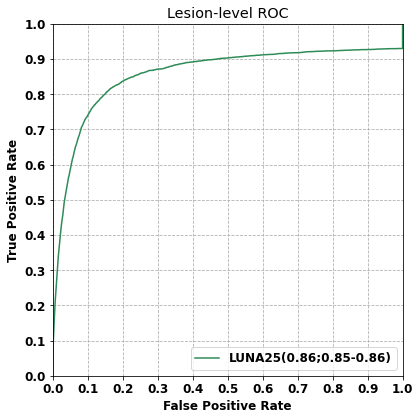

In [7]:
import sys
sys.path.append('/NAS/user_data/user/ft42/LungRADS_Modeling/LungRADS_Detection/')
import pandas as pd
import numpy as np
import json
import csv
import argparse
import os
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter,LogFormatter,StrMethodFormatter,FixedFormatter
import sklearn.metrics as skl_metrics
import seaborn as sns
import numpy as np
import pandas as pd
import warnings
import random
random_seed_Select =200
random.seed(random_seed_Select)
warnings.filterwarnings("ignore")
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams.update({'font.size':12})
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

from eval_utils import*


plt.figure(figsize=(6,6))
plt.rcParams.update({'font.size':12})
plt.rcParams["font.weight"]      = "bold"
plt.rcParams["axes.labelweight"] = "bold"
colors                           = ['#001F3F',  '#4169E1', '#008080', 'brown','pink']




baseModel                                    = pd.read_csv('/NAS/shared_data/for_VNLST/ft42/ct_public/LUNA25/Detection_results/result_DukeLungRADs_cvit_luna16_BaseModel_epoch300_patch192x192y80z_fold1_DukeLungRADs_LUNA25tr_withGT.csv')
baseModel_eval_prob                          = baseModel['probability'].tolist()
baseModel_eval_lbls                          = baseModel['lesion_level_GT'].tolist()
fpr_LL_eval, tpr_LL_eval, thresholds_LL_eval = roc_curve(baseModel_eval_lbls, baseModel_eval_prob)
auc_LL_eval                                  = roc_auc_score(baseModel_eval_lbls, baseModel_eval_prob)
mean_auc, lower, upper                       = compute_auc_ci(np.array(baseModel_eval_lbls),np.array(baseModel_eval_prob), n_bootstraps=1000, alpha=0.95)
plt.plot(fpr_LL_eval, tpr_LL_eval,linestyle='-', color='seagreen', label='LUNA25({:.2f};{:.2f}-{:.2f})'.format(auc_LL_eval,lower,upper))



plt.title('Lesion-level ROC')
plt.xticks(np.arange(0, 1.0, 0.1))
plt.yticks(np.arange(0, 1.0, 0.1))
plt.xticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
plt.yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.grid(which='both', linestyle='--')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()





Avg Sensitivity:0.6027623310913517
0.12-0.22
0.25-0.33
0.50-0.48
1.00-0.64
2.00-0.78
4.00-0.86
8.00-0.90


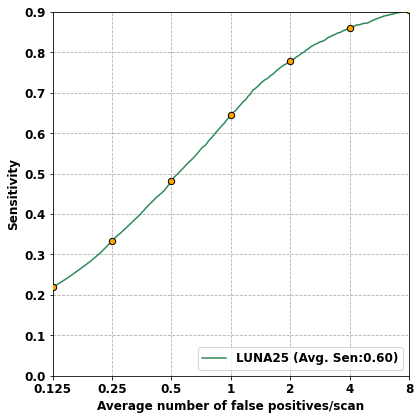

In [11]:
import pandas as pd
import numpy as np
import json
import csv
import argparse
import os
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter,LogFormatter,StrMethodFormatter,FixedFormatter
import sklearn.metrics as skl_metrics
import seaborn as sns
import numpy as np
import pandas as pd
import warnings
import random
random_seed_Select =200
random.seed(random_seed_Select)
import sys
sys.path.append('/NAS/user_data/user/ft42/LungRADS_Modeling/LungRADS_Detection/')
from eval_utils import*

plt.figure(figsize=(6,6))
plt.rcParams.update({'font.size':12})
plt.rcParams["font.weight"]      = "bold"
plt.rcParams["axes.labelweight"] = "bold"

FROC_minX         = 0.125 # Mininum value of x-axis of FROC curve
FROC_maxX         = 8     # Maximum value of x-axis of FROC curve
xmin              = FROC_minX
xmax              = FROC_maxX
false_positive_points = [0.125,0.25,0.5,1,2,4,8]
colors = ['#74c476', '#41ab5d', '#238b45']



baseModel                                    = pd.read_csv('/NAS/shared_data/for_VNLST/ft42/ct_public/LUNA25/Detection_results/result_DukeLungRADs_cvit_luna16_BaseModel_epoch300_patch192x192y80z_fold1_DukeLungRADs_LUNA25tr_withGT.csv')
baseModel_eval_prob                          = baseModel['probability'].tolist()
baseModel_eval_lbls                          = baseModel['lesion_level_GT'].tolist()
baseModel_totalNumberOfImages  = len(np.unique(baseModel['seriesuid'].tolist()))
val_fps, val_sens, val_thresholds                 = computeFROC(baseModel_eval_lbls, baseModel_eval_prob, baseModel_totalNumberOfImages)
val_fps_itp                                       = np.linspace(FROC_minX, FROC_maxX, num=10001)
val_sens_itp                                      = np.interp(val_fps_itp, val_fps, val_sens)
average_sensitivity                               = average_sensitivity_at_false_positive(val_fps, val_sens, false_positive_points)
print('Avg Sensitivity:{}'.format(average_sensitivity))

#plt.plot(val_fps_itp, val_sens_itp,color=colors[2], linestyle='--', lw=1, label='LUNA16-mD (Avg.Sen={:.2f})'.format(average_sensitivity))
plt.plot(val_fps_itp, val_sens_itp,color='seagreen', linestyle='-', lw=1.5, label='LUNA25 (Avg. Sen:{:.2f})'.format(average_sensitivity))

# Add markers and sensitivity values
for fp_point in false_positive_points:
    idx = np.abs(val_fps_itp - fp_point).argmin()
    print('{:.2f}-{:.2f}'.format(fp_point,val_sens_itp[idx]))
    plt.scatter(fp_point, val_sens_itp[idx], color='orange', zorder=5,marker='o',s=40,edgecolors='black')


    

    
plt.xlim(xmin, xmax)
plt.ylim(0, 1)
#plt.title('FROC on External DLCSD24 ')
plt.xlabel('Average number of false positives/scan')
plt.ylabel('Sensitivity')
plt.legend(loc='lower right')
plt.xscale('log', base=2)
plt.xticks([0.125,0.25,0.5,1,2,4,8],['0.125','0.25','0.5','1','2','4','8'])
#plt.xticks([0,1,2,3,4,5,6,7,8])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylim([0,0.9])
plt.grid(which='both',linestyle='--')
# Remove axis lines
plt.tight_layout()
#plt.savefig('Dtection-task-NLST-LESION-LEVEL-FROC.png',bbox_inches="tight",dpi=300)
plt.show()


In [17]:
groud_th_added['lesion_level_GT'].value_counts()

0    63701
1     6190
Name: lesion_level_GT, dtype: int64

In [40]:
Detect_Predict = pd.merge(groud_th_added[['seriesuid', 'coordX', 'coordY', 'coordZ', 'probability', 'w','h', 'd', 'lesion_level_GT', 'gt_coordX', 'gt_coordY', 'gt_coordZ']],
                          Annotation[['seriesuid','CoordX', 'CoordY', 'CoordZ','AnnotationID', 'NoduleID', 'label']],
                          left_on=['seriesuid','gt_coordX', 'gt_coordY', 'gt_coordZ'],
                          right_on=['seriesuid','CoordX', 'CoordY', 'CoordZ'],
                          how='left')

Detect_Predict                      

seriesuid      coordX  \
0      1.2.840.113654.2.55.32380467633296345717423514... -121.597656   
1      1.2.840.113654.2.55.32380467633296345717423514...   65.191895   
2      1.2.840.113654.2.55.32380467633296345717423514...  111.444336   
3      1.2.840.113654.2.55.32380467633296345717423514...  144.606567   
4      1.2.840.113654.2.55.32380467633296345717423514...  -38.804688   
...                                                  ...         ...   
69886  1.3.6.1.4.1.14519.5.2.1.7009.9004.204863242782...   86.034271   
69887  1.3.6.1.4.1.14519.5.2.1.7009.9004.204863242782...  -73.904694   
69888  1.3.6.1.4.1.14519.5.2.1.7009.9004.204863242782... -133.406647   
69889  1.3.6.1.4.1.14519.5.2.1.7009.9004.204863242782...  -59.402740   
69890  1.3.6.1.4.1.14519.5.2.1.7009.9004.204863242782...  -90.691803   

           coordY      coordZ  probability          w          h          d  \
0     -126.068359 -265.751556     0.999023   4.921875   4.921875   4.921875   
1     -165.663086 -179.306244     0.987305  21.137695  21.533203  20.625000   
2     -199.632812 -215.399994     0.974121   4.130859   4.218750   3.906250   
3     -163.333984 -277.392181     0.937988   3.900146   3.867188   3.671875   
4     -172.079102  -65.790619     0.853027   4.921875   5.185547   4.843750   
...           ...         ...          ...        ...        ...        ...   
69886   36.323242 -180.547485     0.032043   3.647461   3.603516   3.750000   
69887  -45.019531 -167.422485     0.026764   4.218750   4.218750   4.375000   
69888   -8.852539 -245.508423     0.024704   2.988281   3.076172   3.203125   
69889   73.193359  -78.516235     0.024521   4.394531   4.394531   4.687500   
69890   38.520508  -80.234985     0.020493   3.339844   3.251953   3.437500   

       lesion_level_GT  gt_coordX  gt_coordY  gt_coordZ  CoordX  CoordY  \
0                    0        0.0        0.0        0.0     NaN     NaN   
1                    0        0.0        0.0        0.0     NaN     NaN   
2                    0        0.0        0.0        0.0     NaN     NaN   
3                    0        0.0        0.0        0.0     NaN     NaN   
4                    0        0.0        0.0        0.0     NaN     NaN   
...                ...        ...        ...        ...     ...     ...   
69886                0        0.0        0.0        0.0     NaN     NaN   
69887                0        0.0        0.0        0.0     NaN     NaN   
69888                0        0.0        0.0        0.0     NaN     NaN   
69889                0        0.0        0.0        0.0     NaN     NaN   
69890                0        0.0        0.0        0.0     NaN     NaN   

       CoordZ AnnotationID NoduleID  label  
0         NaN          NaN      NaN    NaN  
1         NaN          NaN      NaN    NaN  
2         NaN          NaN      NaN    NaN  
3         NaN          NaN      NaN    NaN  
4         NaN          NaN      NaN    NaN  
...       ...          ...      ...    ...  
69886     NaN          NaN      NaN    NaN  
69887     NaN          NaN      NaN    NaN  
69888     NaN          NaN      NaN    NaN  
69889     NaN          NaN      NaN    NaN  
69890     NaN          NaN      NaN    NaN  

[69891 rows x 18 columns]

In [41]:
Detect_Predict_Lesion    = Detect_Predict[Detect_Predict['lesion_level_GT']==1].reset_index(drop=True)
Detect_Predict_nonLesion = Detect_Predict[Detect_Predict['lesion_level_GT']==0].reset_index(drop=True)


In [56]:
Detect_Predict_Lesion = Detect_Predict_Lesion.loc[Detect_Predict_Lesion.groupby('AnnotationID')['probability'].idxmax()]
Detect_Predict_Lesion.to_csv('Detection_results/DukeLungRADs_cvit_luna16_BaseModel_epoch300_Detect_Predict_Lesion.csv',index=False,encoding='utf-8')
Detect_Predict_Lesion

seriesuid      coordX  \
1296  1.2.840.113654.2.55.24023112856488152536348979...  -35.449219   
1297  1.2.840.113654.2.55.50761756412482430061802871...    0.000000   
2021  1.2.840.113654.2.55.64360087057061878755830205...  125.061188   
2022  1.2.840.113654.2.55.33941066798745864774354503...  127.798386   
2023  1.2.840.113654.2.55.17844441025190420803491337...  132.150589   
...                                                 ...         ...   
1478  1.3.6.1.4.1.14519.5.2.1.7009.9004.700680122471... -120.828125   
1479  1.3.6.1.4.1.14519.5.2.1.7009.9004.247237556757... -118.427734   
4778  1.3.6.1.4.1.14519.5.2.1.7009.9004.977896926234...   68.963867   
4779  1.3.6.1.4.1.14519.5.2.1.7009.9004.796552648301...   60.502350   
2795  1.3.6.1.4.1.14519.5.2.1.7009.9004.698887010763...    0.000000   

          coordY      coordZ  probability          w          h          d  \
1296 -136.455078  -88.915619     0.994629  14.062500  13.886719  14.218750   
1297    0.000000    0.000000     0.000000   0.000000   0.000000   0.000000   
2021    5.888474 -194.023438     0.995117   5.339355   5.361328   5.546875   
2022   -2.915039 -185.129700     0.996094   5.427246   5.361328   5.546875   
2023   19.775192 -213.344360     0.929688   4.218750   4.306641   4.218750   
...          ...         ...          ...        ...        ...        ...   
1478 -184.699219 -191.823425     0.849609   7.734375   7.558594   7.734375   
1479 -163.092773 -205.257812     0.993164   7.910156   7.998047   7.890625   
4778  -48.059769  -88.649384     0.998047   7.119141   7.207031   7.031250   
4779   -7.680862  -16.250000     0.999023   7.910156   7.910156   7.812500   
2795    0.000000    0.000000     0.000000   0.000000   0.000000   0.000000   

      lesion_level_GT   gt_coordX  gt_coordY    gt_coordZ      CoordX  \
1296                1  -32.919853 -136.22139   -90.400002  -32.919853   
1297                1  -47.650000 -130.37000  1222.350000  -47.650000   
2021                1  124.670000    5.85000  -193.590000  124.670000   
2022                1  127.360000   -2.95000  -184.570000  127.360000   
2023                1  131.750000   19.73000  -212.860000  131.750000   
...               ...         ...        ...          ...         ...   
1478                1 -120.370000 -184.62000  -192.180000 -120.370000   
1479                1 -118.220000 -162.99000  -205.190000 -118.220000   
4778                1   69.720000  -48.07000   -86.470000   69.720000   
4779                1   61.210000   -7.69000   -15.050000   61.210000   
2795                1   31.260000 -216.76000   250.570000   31.260000   

         CoordY       CoordZ       AnnotationID  NoduleID  label  
1296 -136.22139   -90.400002  100012_1_19990102  100012_1    1.0  
1297 -130.37000  1222.350000  100012_1_20000102  100012_1    1.0  
2021    5.85000  -193.590000  100035_1_19990102  100035_1    0.0  
2022   -2.95000  -184.570000  100035_1_20000102  100035_1    0.0  
2023   19.73000  -212.860000  100035_1_20010102  100035_1    0.0  
...         ...          ...                ...       ...    ...  
1478 -184.62000  -192.180000  218829_1_20000102  218829_1    0.0  
1479 -162.99000  -205.190000  218829_1_20010102  218829_1    0.0  
4778  -48.07000   -86.470000  218863_2_19990102  218863_2    0.0  
4779   -7.69000   -15.050000  218863_2_20010102  218863_2    0.0  
2795 -216.76000   250.570000  218866_1_20000102  218866_1    0.0  

[6163 rows x 18 columns]

In [94]:
Detect_Predict.to_csv('Detection_results/DukeLungRADs_cvit_luna16_BaseModel_epoch300_Detect_Predict.csv',index=False,encoding='utf-8')

<Axes: >

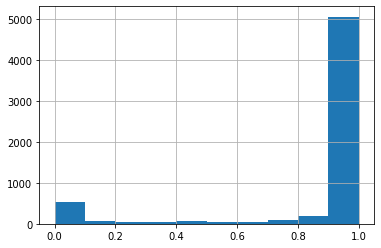

In [55]:
Detect_Predict_Lesion['probability'].hist()

In [ ]:
'/NAS/shared_data/for_VNLST/ft42/ct_public/LUNA25/LUNA25_Public_Training_Development_Data_AnnotationID_nifti.csv'

In [57]:
import cv2
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import math
import pandas as pd
from skimage.measure import label, regionprops

#-| Load Image Functions

def load_itk_image(filename):
    itkimage = sitk.ReadImage(filename)
    numpyImage = sitk.GetArrayFromImage(itkimage)
    numpyOrigin = np.array(list(reversed(itkimage.GetOrigin())))
    numpySpacing = np.array(list(reversed(itkimage.GetSpacing())))
    return numpyImage, numpyOrigin, numpySpacing

def worldToVoxelCoord(worldCoord, origin, spacing):
    stretchedVoxelCoord = np.absolute(worldCoord - origin)
    voxelCoord = stretchedVoxelCoord / spacing
    return np.round(voxelCoord).astype(int)

def normalize_image_to_uint8(image, min_val=-800, max_val=300):
    image = image.astype(np.float32)
    image = np.clip(image, min_val, max_val)
    image = (image - min_val) / (max_val - min_val)
    return (image * 255).astype(np.uint8)

#-| Morphological Filtering with Connected Component Analysis (CCA)

def morphological_filtering(binary_mask, min_size=50, max_size=5000, min_sphericity=0.5):
    """
    Apply Connected Component Analysis to filter out false positives.
    """
    labeled_mask, num_labels = label(binary_mask, return_num=True, connectivity=2)
    filtered_mask = np.zeros_like(binary_mask)

    refined_boxes = []  # List to store the filtered bounding boxes

    for region in regionprops(labeled_mask):
        size = region.area  # Volume in voxels
        perimeter = region.perimeter if region.perimeter > 0 else 1
        
        # Compute sphericity (high values mean rounder shapes)
        sphericity = (np.pi ** (1/3)) * ((6 * size) ** (2/3)) / perimeter

        if min_size <= size <= max_size and sphericity >= min_sphericity:
            filtered_mask[labeled_mask == region.label] = 1  # Keep this component

            # Extract bounding box in voxel coordinates
            min_z, min_y, min_x, max_z, max_y, max_x = region.bbox
            refined_boxes.append([min_x, min_y, min_z, max_x, max_y, max_z])

    return filtered_mask, refined_boxes

#-| Load Ground Truth CSV
gt_csv_path = 'Detection_results/result_DukeLungRADs_cvit_luna16_BaseModel_epoch300_patch192x192y80z_fold1_DukeLungRADs_LUNA25tr_withGT.csv' 
gt_df = pd.read_csv(gt_csv_path)

#-| Load predictions
resampled_img_path = '/data/usr/ft42/nobackup/LUNA25/luna25_images_resampled/'
Final_dect = gt_df['seriesuid'].unique()
problamatic_cases = []

for IM_TO_READ in range(0,1):#nal_dect)):
    try:
        img_name = Final_dect[IM_TO_READ] + '.nii.gz'
        print('|-> Loading the Image:', img_name)

        numpyImage, numpyOrigin, numpySpacing = load_itk_image(filename=resampled_img_path + img_name)
        filter_df = gt_df[gt_df['seriesuid'] == Final_dect[IM_TO_READ]].reset_index(drop=True)

        # Create a 3D binary mask for detected nodules
        binary_mask = np.zeros_like(numpyImage, dtype=np.uint8)

        for index in range(len(filter_df)):
            worldCoord = np.asarray([filter_df.iloc[index].coordZ,
                                     filter_df.iloc[index].coordY,
                                     filter_df.iloc[index].coordX])
            voxelCoord = worldToVoxelCoord(worldCoord, numpyOrigin, numpySpacing)

            w = int(filter_df.iloc[index].w / numpySpacing[2])
            h = int(filter_df.iloc[index].h / numpySpacing[1])
            d = int(filter_df.iloc[index].d / numpySpacing[0])

            start_x, end_x = max(0, voxelCoord[2] - w // 2), min(numpyImage.shape[2], voxelCoord[2] + w // 2)
            start_y, end_y = max(0, voxelCoord[1] - h // 2), min(numpyImage.shape[1], voxelCoord[1] + h // 2)
            start_z, end_z = max(0, voxelCoord[0] - d // 2), min(numpyImage.shape[0], voxelCoord[0] + d // 2)

            binary_mask[start_z:end_z, start_y:end_y, start_x:end_x] = 1

        # Apply Morphological Filtering
        filtered_mask, refined_boxes = morphological_filtering(binary_mask)

        # Convert filtered voxel coordinates back to world coordinates
        filtered_df = []
        for box in refined_boxes:
            min_x, min_y, min_z, max_x, max_y, max_z = box

            coordX = (min_x + max_x) / 2 * numpySpacing[2] + numpyOrigin[2]
            coordY = (min_y + max_y) / 2 * numpySpacing[1] + numpyOrigin[1]
            coordZ = (min_z + max_z) / 2 * numpySpacing[0] + numpyOrigin[0]
            w = (max_x - min_x) * numpySpacing[2]
            h = (max_y - min_y) * numpySpacing[1]
            d = (max_z - min_z) * numpySpacing[0]

            filtered_df.append({'seriesuid': Final_dect[IM_TO_READ], 'coordX': coordX, 'coordY': coordY, 'coordZ': coordZ, 'w': w, 'h': h, 'd': d})

        #filtered_df = pd.DataFrame(filtered_df)

        # Save the filtered boxes
        #filtered_csv_path = 'filtered_nodules.csv'
        #filtered_df.to_csv(filtered_csv_path, mode='a', header=not os.path.exists(filtered_csv_path), index=False)

        # Plot only the filtered boxes
        fig, ax = plt.subplots(figsize=(10, 10))

        for _, row in filtered_df.iterrows():
            voxelCoord = worldToVoxelCoord([row['coordZ'], row['coordY'], row['coordX']], numpyOrigin, numpySpacing)

            w = int(row['w'] / numpySpacing[2])
            h = int(row['h'] / numpySpacing[1])

            start_x, end_x = max(0, voxelCoord[2] - w // 2), min(numpyImage.shape[2], voxelCoord[2] + w // 2)
            start_y, end_y = max(0, voxelCoord[1] - h // 2), min(numpyImage.shape[1], voxelCoord[1] + h // 2)

            draw_box_z = int(voxelCoord[0])
            draw_img = normalize_image_to_uint8(numpyImage[draw_box_z, :, :])
            draw_img = cv2.cvtColor(draw_img, cv2.COLOR_GRAY2BGR)

            draw_img = cv2.rectangle(draw_img, (start_x, start_y), (end_x, end_y), (0, 255, 0), 2)
            
            ax.imshow(draw_img, cmap='gray')
            ax.set_title(f"Filtered Nodule at Z={draw_box_z}")

        plt.axis('off')
        plt.show()

    except Exception as e:
        print('Problem:', e)
        problamatic_cases.append(Final_dect[IM_TO_READ])
        pass


|-> Loading the Image: 1.2.840.113654.2.55.323804676332963457174235140303454945005.nii.gz
Problem: Property perimeter is not implemented for 3D images


In [74]:
import cv2
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import math
import pandas as pd
from skimage.measure import label, regionprops

#-| Load Image Functions

def load_itk_image(filename):
    itkimage = sitk.ReadImage(filename)
    numpyImage = sitk.GetArrayFromImage(itkimage)
    numpyOrigin = np.array(list(reversed(itkimage.GetOrigin())))
    numpySpacing = np.array(list(reversed(itkimage.GetSpacing())))
    return numpyImage, numpyOrigin, numpySpacing

def worldToVoxelCoord(worldCoord, origin, spacing):
    stretchedVoxelCoord = np.absolute(worldCoord - origin)
    voxelCoord = stretchedVoxelCoord / spacing
    return np.round(voxelCoord).astype(int)

def normalize_image_to_uint8(image, min_val=-800, max_val=300):
    image = image.astype(np.float32)
    image = np.clip(image, min_val, max_val)
    image = (image - min_val) / (max_val - min_val)
    return (image * 255).astype(np.uint8)

#-| Morphological Filtering with 3D-Compatible Sphericity Calculation

def morphological_filtering(binary_mask, min_size=100, max_size=10000, min_sphericity=0.5):
    """
    Apply Connected Component Analysis (CCA) to filter out false positives in 3D.
    """
    labeled_mask, num_labels = label(binary_mask, return_num=True, connectivity=2)
    filtered_mask = np.zeros_like(binary_mask)

    refined_boxes = []  # List to store filtered bounding boxes

    for region in regionprops(labeled_mask):
        size = region.area  # Volume in voxels

        # Estimate surface area using convex hull if available
        if hasattr(region, 'convex_area'):
            surface_area = region.convex_area
        else:
            surface_area = ((region.bbox[3] - region.bbox[0]) * 
                            (region.bbox[4] - region.bbox[1]) * 
                            (region.bbox[5] - region.bbox[2])) ** (2/3)

        # Compute sphericity for 3D
        sphericity = (np.pi ** (1/3)) * ((6 * size) ** (2/3)) / surface_area

        if min_size <= size <= max_size and sphericity >= min_sphericity:
            filtered_mask[labeled_mask == region.label] = 1  # Keep this component

            # Extract bounding box in voxel coordinates
            min_z, min_y, min_x, max_z, max_y, max_x = region.bbox
            refined_boxes.append([min_x, min_y, min_z, max_x, max_y, max_z])

    return filtered_mask, refined_boxes

#-| Load Ground Truth CSV
gt_csv_path = 'Detection_results/result_DukeLungRADs_cvit_luna16_BaseModel_epoch300_patch192x192y80z_fold1_DukeLungRADs_LUNA25tr_withGT.csv' 
gt_df = pd.read_csv(gt_csv_path)

#-| Load predictions
resampled_img_path = '/data/usr/ft42/nobackup/LUNA25/luna25_images_resampled/'
Final_dect = gt_df['seriesuid'].unique()
problamatic_cases = []

for IM_TO_READ in range(1,2):
    try:
        img_name = Final_dect[IM_TO_READ] + '.nii.gz'
        print('|-> Loading the Image:', img_name)

        numpyImage, numpyOrigin, numpySpacing = load_itk_image(filename=resampled_img_path + img_name)
        filter_df = gt_df[gt_df['seriesuid'] == Final_dect[IM_TO_READ]].reset_index(drop=True)

        # Create a 3D binary mask for detected nodules
        binary_mask = np.zeros_like(numpyImage, dtype=np.uint8)

        for index in range(len(filter_df)):
            worldCoord = np.asarray([filter_df.iloc[index].coordZ,
                                     filter_df.iloc[index].coordY,
                                     filter_df.iloc[index].coordX])
            voxelCoord = worldToVoxelCoord(worldCoord, numpyOrigin, numpySpacing)

            w = int(filter_df.iloc[index].w / numpySpacing[2])
            h = int(filter_df.iloc[index].h / numpySpacing[1])
            d = int(filter_df.iloc[index].d / numpySpacing[0])

            start_x, end_x = max(0, voxelCoord[2] - w // 2), min(numpyImage.shape[2], voxelCoord[2] + w // 2)
            start_y, end_y = max(0, voxelCoord[1] - h // 2), min(numpyImage.shape[1], voxelCoord[1] + h // 2)
            start_z, end_z = max(0, voxelCoord[0] - d // 2), min(numpyImage.shape[0], voxelCoord[0] + d // 2)

            binary_mask[start_z:end_z, start_y:end_y, start_x:end_x] = 1

        # Apply Morphological Filtering
        filtered_mask, refined_boxes = morphological_filtering(binary_mask)

        # Convert filtered voxel coordinates back to world coordinates
        filtered_df = []
        for box in refined_boxes:
            min_x, min_y, min_z, max_x, max_y, max_z = box

            coordX = (min_x + max_x) / 2 * numpySpacing[2] + numpyOrigin[2]
            coordY = (min_y + max_y) / 2 * numpySpacing[1] + numpyOrigin[1]
            coordZ = (min_z + max_z) / 2 * numpySpacing[0] + numpyOrigin[0]
            w = (max_x - min_x) * numpySpacing[2]
            h = (max_y - min_y) * numpySpacing[1]
            d = (max_z - min_z) * numpySpacing[0]

            filtered_df.append({'seriesuid': Final_dect[IM_TO_READ], 'coordX': coordX, 'coordY': coordY, 'coordZ': coordZ, 'w': w, 'h': h, 'd': d})

        #filtered_df = pd.DataFrame(filtered_df)

        # Save the filtered boxes
        #filtered_csv_path = 'filtered_nodules.csv'
        #filtered_df.to_csv(filtered_csv_path, mode='a', header=not os.path.exists(filtered_csv_path), index=False)

        #print(f"Filtered nodules saved to {filtered_csv_path}")

    except Exception as e:
        print('Problem:', e)
        problamatic_cases.append(Final_dect[IM_TO_READ])
        pass


|-> Loading the Image: 1.2.840.113654.2.55.169309936075332267797085665689677792004.nii.gz


In [75]:
filtered_df

[{'seriesuid': '1.2.840.113654.2.55.169309936075332267797085665689677792004',
  'coordX': 95.58203125,
  'coordY': -124.01171875,
  'coordZ': -114.04998779296875,
  'w': 4.21875,
  'h': 4.21875,
  'd': 5.0},
 {'seriesuid': '1.2.840.113654.2.55.169309936075332267797085665689677792004',
  'coordX': 28.08203125,
  'coordY': -135.96484375,
  'coordZ': -94.04998779296875,
  'w': 4.21875,
  'h': 4.21875,
  'd': 5.0}]

In [88]:
gt_df[gt_df['seriesuid']=='1.2.840.113654.2.55.265319828882031934123900223553642015735']

index                                          seriesuid     coordX  \
1553  23990  1.2.840.113654.2.55.26531982888203193412390022... -53.652344   
1554  23991  1.2.840.113654.2.55.26531982888203193412390022... -81.250000   
1555  23992  1.2.840.113654.2.55.26531982888203193412390022... -84.414062   
1556  23993  1.2.840.113654.2.55.26531982888203193412390022... -98.828125   
1557  23994  1.2.840.113654.2.55.26531982888203193412390022... -73.691406   
1558  23995  1.2.840.113654.2.55.26531982888203193412390022... -83.183594   
1559  23996  1.2.840.113654.2.55.26531982888203193412390022...  98.596191   
1560  23997  1.2.840.113654.2.55.26531982888203193412390022...  17.583008   
1561  23998  1.2.840.113654.2.55.26531982888203193412390022...  60.209961   

          coordY      coordZ  probability          w          h          d  \
1553 -191.535156 -101.646881     0.995605   6.328125   6.328125   6.406250   
1554 -215.880859 -147.818756     0.984863   4.570312   4.746094   4.687500   
1555 -206.037109 -173.443756     0.854492  17.578125  17.050781  15.468750   
1556 -180.636719 -137.350006     0.201050   3.515625   3.515625   3.437500   
1557 -197.599609 -174.107819     0.149170  20.390625  17.402344  18.046875   
1558 -159.762695  -41.646881     0.046295   3.515625   3.427734   3.593750   
1559 -153.566406 -173.248444     0.045197   6.987305   6.679688   6.796875   
1560  -69.960449 -181.568756     0.034882   6.240234   6.196289   6.250000   
1561  -86.505859  -75.631256     0.030624   3.603516   3.691406   3.750000   

      lesion_level_GT  ...  AnnotationID  NoduleID  label  Age_at_StudyDate  \
1553                0  ...           NaN       NaN    NaN               NaN   
1554                1  ...           NaN       NaN    NaN               NaN   
1555                0  ...           NaN       NaN    NaN               NaN   
1556                0  ...           NaN       NaN    NaN               NaN   
1557                0  ...           NaN       NaN    NaN               NaN   
1558                0  ...           NaN       NaN    NaN               NaN   
1559                0  ...           NaN       NaN    NaN               NaN   
1560                0  ...           NaN       NaN    NaN               NaN   
1561                0  ...           NaN       NaN    NaN               NaN   

      Gender AnnotationID_nifti  path  softmax  npy_id  class  
1553     NaN                NaN   NaN      NaN     NaN    NaN  
1554     NaN                NaN   NaN      NaN     NaN    NaN  
1555     NaN                NaN   NaN      NaN     NaN    NaN  
1556     NaN                NaN   NaN      NaN     NaN    NaN  
1557     NaN                NaN   NaN      NaN     NaN    NaN  
1558     NaN                NaN   NaN      NaN     NaN    NaN  
1559     NaN                NaN   NaN      NaN     NaN    NaN  
1560     NaN                NaN   NaN      NaN     NaN    NaN  
1561     NaN                NaN   NaN      NaN     NaN    NaN  

[9 rows x 31 columns]

In [85]:
import cv2
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import math
import pandas as pd
from skimage.measure import label, regionprops

#-| Load Image Functions

def load_itk_image(filename):
    itkimage = sitk.ReadImage(filename)
    numpyImage = sitk.GetArrayFromImage(itkimage)
    numpyOrigin = np.array(list(reversed(itkimage.GetOrigin())))
    numpySpacing = np.array(list(reversed(itkimage.GetSpacing())))
    return numpyImage, numpyOrigin, numpySpacing

def worldToVoxelCoord(worldCoord, origin, spacing):
    stretchedVoxelCoord = np.absolute(worldCoord - origin)
    voxelCoord = stretchedVoxelCoord / spacing
    return np.round(voxelCoord).astype(int)

def normalize_image_to_uint8(image, min_val=-800, max_val=300):
    image = image.astype(np.float32)
    image = np.clip(image, min_val, max_val)
    image = (image - min_val) / (max_val - min_val)
    return (image * 255).astype(np.uint8)

#-| Morphological Filtering with Probability Consideration

def morphological_filtering(binary_mask, probability_map, min_size=100, max_size=10000, min_sphericity=0.5, prob_threshold=0.5):
    """
    Apply Connected Component Analysis (CCA) to filter out false positives in 3D.
    Also considers probability scores for filtering.

    Args:
        binary_mask (numpy array): 3D binary mask of detected nodules.
        probability_map (numpy array): 3D probability map of detection confidences.
        min_size (int): Minimum voxel size for valid nodules.
        max_size (int): Maximum voxel size for valid nodules.
        min_sphericity (float): Minimum sphericity threshold.
        prob_threshold (float): Minimum probability threshold.

    Returns:
        filtered_mask (numpy array): Binary mask with valid nodules.
        refined_boxes (list): Bounding boxes for kept nodules.
        removed_boxes (list): Bounding boxes for rejected nodules.
    """
    labeled_mask, num_labels = label(binary_mask, return_num=True, connectivity=2)
    filtered_mask = np.zeros_like(binary_mask)

    refined_boxes = []  # List of retained nodules
    removed_boxes = []  # List of removed false positives

    for region in regionprops(labeled_mask):
        size = region.area  # Volume in voxels
        min_z, min_y, min_x, max_z, max_y, max_x = region.bbox

        # Extract probability within the bounding box
        prob_region = probability_map[min_z:max_z, min_y:max_y, min_x:max_x]
        mean_probability = np.mean(prob_region)

        # Estimate surface area using convex hull if available
        if hasattr(region, 'convex_area'):
            surface_area = region.convex_area
        else:
            surface_area = ((max_z - min_z) * (max_y - min_y) * (max_x - min_x)) ** (2/3)

        # Compute sphericity for 3D
        sphericity = (np.pi ** (1/3)) * ((6 * size) ** (2/3)) / surface_area

        # Apply probability threshold and morphology constraints
        if mean_probability >= prob_threshold and min_size <= size <= max_size and sphericity >= min_sphericity:
            filtered_mask[labeled_mask == region.label] = 1  # Keep this component
            refined_boxes.append([min_x, min_y, min_z, max_x, max_y, max_z, mean_probability])
        else:
            removed_boxes.append([min_x, min_y, min_z, max_x, max_y, max_z, mean_probability])

    return filtered_mask, refined_boxes, removed_boxes

#-| Load Ground Truth CSV
gt_csv_path = 'Detection_results/result_DukeLungRADs_cvit_luna16_BaseModel_epoch300_patch192x192y80z_fold1_DukeLungRADs_LUNA25tr_withGT.csv' 
gt_df = pd.read_csv(gt_csv_path)

#-| Load predictions
resampled_img_path = '/data/usr/ft42/nobackup/LUNA25/luna25_images_resampled/'
Final_dect = gt_df['seriesuid'].unique()
problamatic_cases = []

prob_threshold = 0.3  # Set your desired probability threshold

for IM_TO_READ in range(100,101):
    try:
        img_name = Final_dect[IM_TO_READ] + '.nii.gz'
        print('|-> Loading the Image:', img_name)

        numpyImage, numpyOrigin, numpySpacing = load_itk_image(filename=resampled_img_path + img_name)
        filter_df = gt_df[gt_df['seriesuid'] == Final_dect[IM_TO_READ]].reset_index(drop=True)

        # Create a 3D binary mask and probability map for detected nodules
        binary_mask = np.zeros_like(numpyImage, dtype=np.uint8)
        probability_map = np.zeros_like(numpyImage, dtype=np.float32)

        for index in range(len(filter_df)):
            worldCoord = np.asarray([filter_df.iloc[index].coordZ,
                                     filter_df.iloc[index].coordY,
                                     filter_df.iloc[index].coordX])
            voxelCoord = worldToVoxelCoord(worldCoord, numpyOrigin, numpySpacing)

            w = int(filter_df.iloc[index].w / numpySpacing[2])
            h = int(filter_df.iloc[index].h / numpySpacing[1])
            d = int(filter_df.iloc[index].d / numpySpacing[0])

            start_x, end_x = max(0, voxelCoord[2] - w // 2), min(numpyImage.shape[2], voxelCoord[2] + w // 2)
            start_y, end_y = max(0, voxelCoord[1] - h // 2), min(numpyImage.shape[1], voxelCoord[1] + h // 2)
            start_z, end_z = max(0, voxelCoord[0] - d // 2), min(numpyImage.shape[0], voxelCoord[0] + d // 2)

            binary_mask[start_z:end_z, start_y:end_y, start_x:end_x] = 1
            probability_map[start_z:end_z, start_y:end_y, start_x:end_x] = filter_df.iloc[index].probability

        # Apply Morphological Filtering with Probability Constraint
        filtered_mask, refined_boxes, removed_boxes = morphological_filtering(
            binary_mask, probability_map, prob_threshold=prob_threshold
        )
        
        # Convert filtered voxel coordinates back to world coordinates
        filtered_df = []
        for box in refined_boxes:
            min_x, min_y, min_z, max_x, max_y, max_z,probability = box

            coordX = (min_x + max_x) / 2 * numpySpacing[2] + numpyOrigin[2]
            coordY = (min_y + max_y) / 2 * numpySpacing[1] + numpyOrigin[1]
            coordZ = (min_z + max_z) / 2 * numpySpacing[0] + numpyOrigin[0]
            w = (max_x - min_x) * numpySpacing[2]
            h = (max_y - min_y) * numpySpacing[1]
            d = (max_z - min_z) * numpySpacing[0]

            filtered_df.append({'seriesuid': Final_dect[IM_TO_READ], 'coordX': coordX, 'coordY': coordY, 'coordZ': coordZ, 'w': w, 'h': h, 'd': d})

    except Exception as e:
        print('Problem:', e)
        problamatic_cases.append(Final_dect[IM_TO_READ])
        pass


|-> Loading the Image: 1.2.840.113654.2.55.265319828882031934123900223553642015735.nii.gz
